# Variational Inference

We will look at two different variational methods to infer an interpretable structure from a streaming high-dimensional time series: sequential variational encoder (seqVAE) and variational joint filtering (VJF).



In [39]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol
from vjf.model import VJF
from code_pack.plotting import plot_two_d_vector_field_from_data
import math
from einops import rearrange

from vanderpol.config import get_cfg_defaults
cfg = get_cfg_defaults()

In [40]:
# Setup precision and random seeds
torch.set_default_dtype(torch.double)  # using double precision
torch.manual_seed(0)
np.random.seed(0);

In [41]:
def grid(n, lims):
    xedges = np.linspace(*lims, n)
    yedges = np.linspace(*lims, n)
    X, Y = np.meshgrid(xedges, yedges)
    grids = np.column_stack([X.reshape(-1), Y.reshape(-1)])
    return X, Y, grids

### Load data

In [42]:
cfg = get_cfg_defaults()
data = h5py.File('vanderpol/data/poisson_obs.h5')
Y = torch.tensor(np.array(data['Y']), dtype=torch.float32)
X = torch.tensor(np.array(data['X']), dtype=torch.float32)
C = torch.tensor(np.array(data['C']), dtype=torch.float32)
b = torch.tensor(np.array(data['bias']), dtype=torch.float32)

## Sequential Variational AutoEncoder

We demonstrate that seqVAE can learn the latent dynamical system.
For fast convergence, we fix the observation model parameters $C$ and $b$.

In [43]:
from IPython.display import display, clear_output
from vanderpol.SequentialVAE import NeuralVAE, SeqDataLoader

n_epochs = 150
batch_size = 25
time_delta = 5e-3

n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

In [44]:
vae = NeuralVAE(cfg, time_delta, n_neurons, n_latents, n_time_bins)
vae.manually_set_readout_params(C.clone(), b.clone())

vae.decoder.C.bias.requires_grad_(False)
vae.decoder.C.weight.requires_grad_(False)
train_data_loader = SeqDataLoader((Y, X), batch_size)

opt = torch.optim.Adam(vae.parameters(), lr=1e-2)

## Training the Sequence VAE
We will now train the sequence VAE using synthetic Poisson observations with spiking rate modulated by Van der Pol dynamics.  The generative model is
$$
z_{t+1} = f(z_t) + w_t\\
y_t \mid z_t \sim \text{Poisson}(y_t \mid \Delta \exp(C^\top z_t + b))
$$
To perform one gradient step, the only thing we must do is evaluate the ELBO
$$
\mathcal{L}(\theta, \phi, \psi) = \sum\nolimits_t \mathbb{E}_{q_{\phi}(z_t)} \log p_{\psi}(y_t \mid z_t) - \mathbb{D}_{\text{KL}} (q_{\phi}(z_{1:T}) \,||\, p_{\theta}(z_{1:T}))
$$
In convenient cases, we can calculate some of these expectations analytically.  However, for general non-linear and non-Gaussian dynamics we cannot.  Fortunately, our structured representation of the variational approximation makes it easy to sample trajectories from the current distribution so that we can use stochastic gradients instead.


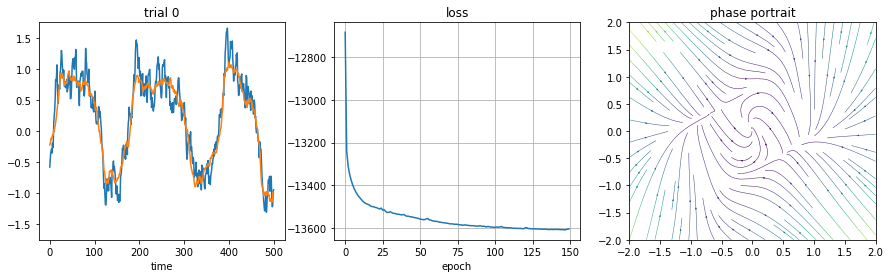

In [45]:
%matplotlib notebook
%matplotlib inline

total_loss = []
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs_range = {'x_min': -1.5, 'x_max': 1.5,
             'y_min': -1.5, 'y_max': 1.5}


for epoch in range(n_epochs):
    batch_loss = []

    for batch_idx, (y, x) in enumerate(train_data_loader):
        loss, z, mu_t, log_var_t = vae(y, y, 1.0)
        batch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()

    total_loss.append(np.mean(batch_loss))

    if epoch % 1 == 0:
        axs[0].cla()
        axs[0].set_ylim(-1.75, 1.75)
        axs[0].plot(z[:, 0, 0].detach().numpy())
        axs[0].plot(x[0, :, 0].detach().numpy())
        axs[0].set_xlabel('time'); axs[0].set_title('trial 0')

        axs[1].set_xlim(0, epoch)
        axs[1].cla()
        axs[1].plot(total_loss)
        axs[1].set_title('loss'); axs[1].set_xlabel('epoch'); axs[1].grid(True)

        display(fig)
        clear_output(wait=True)

    if epoch % 5 == 0:
        with torch.no_grad():
            axs[2].cla()
            dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])
            plot_two_d_vector_field_from_data(dynamics_fn, axs[2], axs_range)
            axs[2].set_title('phase portrait')

dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])

## Evaluating K-step predictions
We see how well the learned dynamics can do k-step predictions

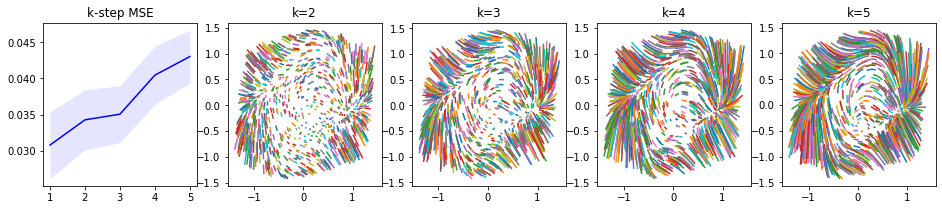

In [120]:
# vdp parameters, we just compare the deterministic dynamics
import scipy.stats

system_parameters = {}
system_parameters['mu'] = 1.5
system_parameters['tau_1'] = 0.1
system_parameters['tau_2'] = 0.1
system_parameters['sigma'] = 0.0  # (no noise for comparison)
system_parameters['scale'] = 1 / 0.4

k_step_max = 5  # 3 or greater
n_samples = 1000
mse_per_sample = torch.zeros(n_samples, k_step_max, dtype=torch.float32)
fig, axs = plt.subplots(1, k_step_max, figsize=((k_step_max-1)*4, 3))

for k_steps in range(1, k_step_max + 1):

    for n in range(n_samples):
        x0 = torch.tensor([-1.5, -1.5], dtype=torch.float32) + 3 * torch.rand(2, dtype=torch.float32)

        xs_pr = torch.zeros((k_steps, 2), dtype=torch.float32) # predicted xs passed through learned dynamics
        xs_gt = generate_noisy_van_der_pol(x0, time_delta * np.arange(k_steps+1), system_parameters)[1:] # xs passed through ground truth dynamics

        for i in range(k_steps):
            if i == 0:
                xs_pr[i] = dynamics_fn(x0)
            else:
                xs_pr[i] = dynamics_fn(xs_pr[i-1])

        mse = torch.mean((torch.tensor(xs_gt) - xs_pr)**2)
        mse_per_sample[n, k_steps-1] = mse

        if k_steps > 1:
            axs[k_steps-1].plot(xs_pr[:, 0].detach().numpy(), xs_pr[:, 1].detach().numpy())
            axs[k_steps-1].set_title(f'k={k_steps}')

mse_k_step = torch.mean(mse_per_sample, dim=0).detach()
sem_k_step = scipy.stats.sem(mse_per_sample.detach(), axis=0)

axs[0].set_title(f'k-step MSE')
axs[0].plot(np.arange(1, k_step_max+1), mse_k_step, color='blue')
axs[0].fill_between(np.arange(1, k_step_max+1),
                    mse_k_step + 2 * sem_k_step,
                    mse_k_step - 2 * sem_k_step,
                    color='blue', linewidth=0, alpha=0.1)

## Variational Joint Filtering
A *real-time* method for variationally filtering latent trajectories and learning their underlying dynamics. An approximation to the filtering distribution is used at each time point to evaluate the time instantaneous ELBO; this makes it possible for us to infer latent states while *simultaneously* learning the dynamics

See the paper [here](https://www.frontiersin.org/articles/10.3389/fncom.2020.00071/full).
See the code [here](https://github.com/catniplab/vjf).

In [46]:
delta = 5e-3  # time bin size
n_trials = 1
bin_size_ms = 5
time_delta = bin_size_ms * 1e-3

state0 = np.random.uniform(-1.0, 1.0, size=2)
    
system_parameters = {}
system_parameters['mu'] = 1.5
system_parameters['tau_1'] = 0.1
system_parameters['tau_2'] = 0.1
system_parameters['sigma'] = 0.1  # noise add into euler integration
system_parameters['scale'] = 1 / 0.4

In [ ]:
#generate latent
n_latents = 2
n_neurons = 50
n_time_bins = 2000
t = delta * torch.arange(n_time_bins)
X = generate_noisy_van_der_pol(state0, t, system_parameters)

X = X @ np.array([[4,0],[0,4]]) 

#generate observations Guassian observations
C = np.random.normal(size=(n_latents, n_neurons))  # loading matrix
b = np.random.normal(size=n_neurons)               # bias

# observation
Y = X @ C + b
Y = Y + np.random.normal(size=Y.shape) * 0.1  # add some noise

n_epochs = 15
batch_size = 25
time_delta = 5e-3

In [ ]:
# Setup and fit VJF 
udim = 0
n_rbf = 50  # number of radial basis functions for dynamical system
hidden_sizes = [20]  # size of hidden layers of recognition model
likelihood = 'gaussian'  # gaussian or poisson

model_gauss = VJF.make_model(n_neurons, n_latents, udim=udim, n_rbf=n_rbf, hidden_sizes=hidden_sizes, likelihood=likelihood)
m_gauss, logvar, _ = model_gauss.fit(Y, max_iter=150)  # fit and return list of state posterior tuples (mean, log variance)

m_gauss = m_gauss.detach().numpy().squeeze()
s_gauss = np.exp(0.5 * logvar.detach().numpy().squeeze())

In [ ]:
# regress to account for invariance
X_hat = m_gauss #rearrange(m_vdp, 'batch time lat ->  (batch time) lat')
S = np.linalg.pinv(X_hat) @ X.reshape(n_time_bins, n_latents)
X_hat_tilde = X_hat @ S
X_hat_tilde = X_hat_tilde.reshape(n_time_bins, n_latents)

# Plot
fig, axs = plt.subplots(2, 1, sharex='all')

axs[0].plot(X[:, 0], color='black', alpha=0.75)
axs[0].set_ylabel('dim0')
axs[0].set_xlabel('time')
axs[0].plot(X_hat_tilde[:, 0], color='red', alpha=0.75)
axs[0].fill_between(np.arange(n_time_bins),
                    X_hat_tilde[:, 0] + 2 * s_gauss[:, 0],
                    X_hat_tilde[:, 0] - 2 * s_gauss[:, 0],
                    color='red', alpha=0.1, linewidth=0)

axs[1].plot(X[:, 1], color='black', alpha=0.75)
axs[1].set_ylabel('dim1')
axs[1].plot(X_hat_tilde[:, 1], color='red', alpha=0.75)
axs[1].fill_between(np.arange(n_time_bins),
                    X_hat_tilde[:, 1] + 2 * s_gauss[:, 1],
                    X_hat_tilde[:, 1] - 2 * s_gauss[:, 1],
                    color='red', alpha=0.1, linewidth=0)
plt.legend(["Data", "Fit"], loc='upper right');

In [ ]:
# Draw the inferred velocity field

ax = fig.add_subplot(223)
r = np.mean(np.abs(m_gauss).max())  # determine the limits of plot

Xm, Ym, XYm = grid(51, [-1.5*r, 1.5*r])
Um, Vm = model_gauss.transition.velocity(torch.tensor(XYm)).detach().numpy().T  # get velocity
Um = np.reshape(Um, Xm.shape)
Vm = np.reshape(Vm, Ym.shape)
plt.streamplot(Xm, Ym, Um, Vm)
plt.plot(*m_gauss.T, color='C1', alpha=0.5, zorder=5)
plt.title('Velocity field');